# Import du fichier d'exemples


In [0]:
def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", raw_samples_file)
        print(" Done")

    with gzip.open(raw_samples_file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

In [0]:
data = get_raw_data_go()
print("We have", len(data),"examples")

File samples-9x9.json.gz not found, I am downloading it... Done
We have 41563 examples


# First steps: transform all the data into numpy arrays to feed your neural network



In [0]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

To encode the board to be able to use it as an input vector to feed our neural network, we implemented three encoder:
- one plane encoder: is a simple matrix (one plane) of board size where white stones are represented as -1, black stones as 1 and 0 if it's empty.
- two plane encoder:  One plane for black and one plane for white, with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane, as you proposed in the notebook.
- three plane encoder: is similar to the two plane encoder except that we have added the third plane which represent the next player considering that the next player has an advantage over the other player.

After comparasion between the three encoder, we have noted that the third one leds to better performance in prediction so we chose to use it.

To enrich our dataset with all symmetries and rotations, the encoder doesn't encode the original dataset only but also it generates all the symmetries by using numpy.rot90() and numpy.flipud().

In [0]:
def one_plane_encoder(data):
  """take as an input the json file and returns two arrays
    the frist array is the board state and the second array 
    is the probabilities that black wins
  """
  X = []
  Y = []
  for i in range(len(data)): 
      board = np.zeros((9,9), dtype=np.float32)
      black = data[i]["black_stones"]
      white = data[i]["white_stones"]
      
      for j in range(len(black)):
          x,y = name_to_coord(black[j])
          board[x,y] = 1
      for j in range(len(white)):
          x,y = name_to_coord(white[j])
          board[x,y] = -1
      X.append(board)
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=1))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=2))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=3))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      board = np.flipud(board)
      X.append(board)
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=1))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=2))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
      X.append(np.rot90(board, k=3))
      Y.append(data[i]["black_wins"]/data[i]["rollouts"])
      
  X_data = np.array(X)
  Y_data = np.array(Y)
  print(X_data.shape)
  print(Y_data.shape)
  return X_data, Y_data

In [0]:
def two_planes_encoder(data):
    """ take as an input the json file and returns two arrays
    the frist array is the board state and the second array 
    is the probabilities that black wins
    """
    X = []
    Y = []
    for i in range(len(data)): 
        black_stones = np.zeros((9,9), dtype=np.float32)
        white_stones = np.zeros((9,9), dtype=np.float32)
        black = data[i]["black_stones"]
        white = data[i]["white_stones"]
        
        for j in range(len(black)):
            x,y = name_to_coord(black[j])
            black_stones[x,y] = 1
        for j in range(len(white)):
            x,y = name_to_coord(white[j])
            white_stones[x,y] = 1
        img = np.dstack((black_stones,white_stones))
        X.append(img)
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        img = np.flipud(img)
        X.append(img)
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
    X_data = np.array(X)
    Y_data = np.array(Y)
    print(X_data.shape)
    print(Y_data.shape)
    return X_data, Y_data

In [0]:
def three_planes_encoder(data):
    """take as an input the json file and returns two arrays
    the frist array is the board state and the second array 
    is the probabilities that black wins
    """
    X = []
    Y = []
    for i in range(len(data)): 
        black_stones = np.zeros((9,9), dtype=np.float32)
        white_stones = np.zeros((9,9), dtype=np.float32)
        player_turn = np.zeros((9,9), dtype=np.float32)
        black = data[i]["black_stones"]
        white = data[i]["white_stones"]
        
        for j in range(len(black)):
            x,y = name_to_coord(black[j])
            black_stones[x,y] = 1
        for j in range(len(white)):
            x,y = name_to_coord(white[j])
            white_stones[x,y] = 1
        if (len(data[i]["list_of_moves"])%2 == 0):
          # black turn 1, white turn 0
          player_turn = np.ones((9,9), dtype=np.float32)
        img = np.dstack((black_stones,white_stones,player_turn))
        X.append(img)
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        img = np.flipud(img)
        X.append(img)
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(data[i]["black_wins"]/data[i]["rollouts"])
        
    X_data = np.array(X)
    Y_data = np.array(Y)
    print(X_data.shape)
    print(Y_data.shape)
    return X_data, Y_data

In [0]:
X_data, Y_data = three_planes_encoder(data)
#np.savez('./dataset', X=X_data, Y=Y_data)

(332504, 9, 9, 3)
(332504,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.33)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train =Y_train.astype('float32')
Y_test = Y_test.astype('float32')
print(X_train.shape)
print(X_test.shape)

(299253, 9, 9, 3)
(33251, 9, 9, 3)


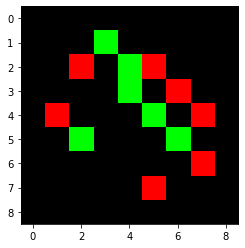

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

# Second steps: build your neural network and train it


In [0]:
def calculate_error(Y_pred,Y_test):
  res = [0]*6
  for i in range(len(Y_pred)):
    val = abs(Y_pred[i]-Y_test[i])
    if val <= 0.05:
      res[0]+=1
    elif val <= 0.10:
      res[1]+=1
    elif val <= 0.20:
      res[2]+=1
    elif val <= 0.35:
      res[3]+=1
    elif val <= 0.50:
      res[4]+=1
    else:
      res[5]+=1
  return [x / len(Y_pred) for x in res]

## Important points in the model:
- In the convolution layer, we added the attribut padding In order not to downsize the image because we don't want to ignore the stones on the borders.
- for the activation function in the output layer, we chose sigmoid function because it exists between (0 to 1) and it is especially used for models where we have to predict the probability as an output. So we think it is the best choice in our case since we have to predict the probability that black wins.
- To avoid the overfitting we used the technique of dropout.
- for the metrics, we chose the MeanSquaredError and MeanAbsoluteError because they reflect how we want the loss to be calculated which the difference between the reel and predicted value.

In [0]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

epochs = 200
batch_size = 1024

model = Sequential([
    Conv2D(64, (5, 5), padding='same', activation = 'relu', data_format='channels_last', input_shape=(9,9,3)),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(48, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(48, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(rate=0.5),
    Dense(81, activation = 'relu'),
    Dropout(rate=0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

model.summary()

Found GPU at: /device:GPU:0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 64)          4864      
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)           

In [0]:
history = model.fit(X_data, Y_data, 
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1)

Epoch 1/200
325/325 [==============================] - 8s 23ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2468
Epoch 2/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1564
Epoch 3/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1432
Epoch 4/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0432 - mse: 0.0432 - mae: 0.1369
Epoch 5/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1333
Epoch 6/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1296
Epoch 7/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1279
Epoch 8/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0383 - mse: 0.0383 - mae: 0.1261
Epoch 9/200
325/325 [==============================] - 7s 23ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1248
E

In [0]:
res = calculate_error(model.predict(X_test),Y_test)
for i in range(6):
  print("%.2f" % (res[i]))

0.51
0.19
0.20
0.07
0.02
0.01


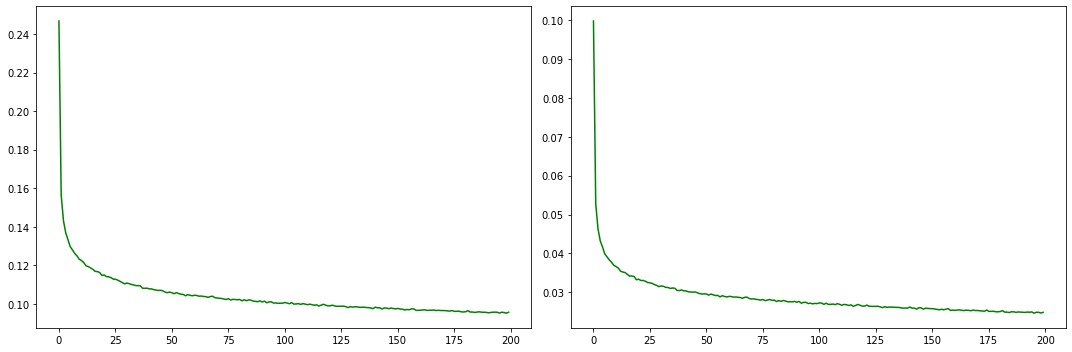

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
#axes[0].title('mae')
axes[0].plot(history.history['mae'], 'g')
#axes[0].plot(history.history['val_mae'], 'r')
#axes[1].title('mse')
axes[1].plot(history.history['mse'], 'g')
#axes[1].plot(history.history['val_mse'], 'r')
fig.tight_layout()

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...


In [0]:
def get_raw_data_go_prediction():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "positions-to-evaluate-9x9-attempt.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz", raw_samples_file)
        print(" Done")

    with gzip.open(raw_samples_file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

In [0]:
def three_planes_encoder_prediction(data):
    X = []
    for i in range(len(data)): 
        black_stones = np.zeros((9,9), dtype=np.float32)
        white_stones = np.zeros((9,9), dtype=np.float32)
        player_turn = np.zeros((9,9), dtype=np.float32)
        black = data[i]["black_stones"]
        white = data[i]["white_stones"]
        for j in range(len(black)):
            x,y = name_to_coord(black[j])
            black_stones[x,y] = 1
        for j in range(len(white)):
            x,y = name_to_coord(white[j])
            white_stones[x,y] = 1
        if (len(data[i]["list_of_moves"])%2 == 0):
          # black turn 1, white turn 0
          player_turn = np.ones((9,9), dtype=np.float32)
        img = np.dstack((black_stones,white_stones,player_turn))
        X.append(img)
    X_data = np.array(X)
    print(X_data.shape)
    return X_data

In [0]:
def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    y_predicted = model.predict(newdata)
    with open("my_predictions.txt", "w") as f:
         for i in range(len(y_predicted)):
           p = y_predicted[i][0]
           f.write(str(p)+"\n")

In [0]:
data_to_predict = get_raw_data_go_prediction()
x_to_predict = three_planes_encoder_prediction(data_to_predict)
x_to_predict = x_to_predict.astype('float32')
create_result_file(x_to_predict)

File positions-to-evaluate-9x9-attempt.json.gz not found, I am downloading it... Done
(1000, 9, 9, 3)
